In [1]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl

In [49]:
# Helper Function - heatmap
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw=None, cbarlabel="", ignorebar=False, ignorewf=False, **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (M, N).
    row_labels
        A list or array of length M with the labels for the rows.
    col_labels
        A list or array of length N with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current Axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if ax is None:
        ax = plt.gca()

    if cbar_kw is None:
        cbar_kw = {}  # find out the arguments and set the minimum/bottom to be 0, and the maximum/top to be 100 -- that way the scaling is consistent !

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    if not ignorebar:
        # Create colorbar
        cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
        cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")
        cbar.mappable.set_clim(0, 100)

    # Show all ticks and label them with the respective list entries.
    ax.set_xticks(range(data.shape[1]), labels=col_labels,
                  rotation=-30, ha="right", rotation_mode="anchor")
    ax.set_yticks(range(data.shape[0]), labels=row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Turn spines off and create white grid.
    #ax.spines[:].set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    if ignorewf:
        ax.set_yticks([])
        ax.set_yticks([], minor=True)

    if ignorebar:
        return im, None
    else:
        return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=("black", "white"),
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A pair of colors.  The first is used for values below a threshold,
        the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    threshold = 75

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = mpl.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            if valfmt(data[i, j]) == '100':
                text = im.axes.text(j, i, 'X', **kw)
            else:
                text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

In [3]:
# Parse Explorer Summary (NEW)
def parse_explorer_summary(explorer_data):
    with open(explorer_data, 'r') as f:
        data = [line.strip().split(',') for line in f.readlines()]

    for row in data:
        if '~' in row[0]:
            shift_ms = row[0].split('~')[1][:-4]
            days = int(shift_ms.split('-')[0])
            hours = int(shift_ms.split('-')[1])
            shift_h = (days * 24) + hours
            row[0] = shift_h
        else:
            row[0] = 0

    data_d = {}

    for row in data:
        data_d[row[0]] = {'emissions': row[1]}

    return data_d


def get_minimum(data):
    minimum = float(data[0]['emissions'])
    shift = 0

    for key, entry in data.items():
        if float(entry['emissions']) < minimum:
            minimum = float(entry['emissions'])
            shift = key

    return (shift, minimum)


def get_reduction(original, new):
    orig = float(original)
    neww = float(new)
    return ((orig - neww) / abs(orig)) * 100


def overview(trace, print=False):
    data = parse_explorer_summary(trace)
    (min_shift, min_emissions) = get_minimum(data)

    if print:
        print(f"Original [0] CCF {data[0]['emissions']} gCO2e")  # original
        print(f"Minimum [{min_shift}] CCF {min_emissions} gCO2e")  # minimum
        print(f"Reduction {get_reduction(data[0]['emissions'], min_emissions):.2f}%")

    return (data, min_shift, min_emissions)


def average(one, two, three):
    return (float(one) + float(two) + float(three)) / 3

In [4]:
# Constants
regions = ['Great Britain', 'Germany', 'California', 'Texas', 'South Africa', 'Tokyo', 'New South Wales']
short_regions = ['gb', 'de', 'ca', 'tx', 'zaf', 'tyo', 'nsw']
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
short_months = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec'] 
month_dates = ['08012024-13012024', '12022024-17022024', '11032024-16032024',  
    '08042024-13042024', '13052024-18052024', '10062024-15062024',  
    '08072024-13072024', '12082024-17082024', '09092024-14092024',  
    '14102024-19102024', '11112024-16112024', '09122024-14122024']
region_folders = [f'../data/results/entire-wf-shifting/out/{region}/' for region in short_regions]
workflows=['chipseq', 'mag', 'montage', 'nanoseq', 'rangeland', 'rnaseq', 'sarek']

In [5]:
# Parse Readings for all readings, through the year
def parse_readings(window, marg=''):
    data = {}

    for folder, region in zip(region_folders, short_regions):
        reduction_by_workflow = {}

        for i in range(0, 12):
            for workflow in workflows:
                path_one = f'{folder}explorer-{window}h-{workflow}-{short_months[i]}-1-{region}-{month_dates[i]}{marg}~footprint.csv'
                path_two = f'{folder}explorer-{window}h-{workflow}-{short_months[i]}-2-{region}-{month_dates[i]}{marg}~footprint.csv'
                path_three = f'{folder}explorer-{window}h-{workflow}-{short_months[i]}-3-{region}-{month_dates[i]}{marg}~footprint.csv'

                (data_1, _, min_emissions_1) = overview(path_one)
                (data_2, _, min_emissions_2) = overview(path_two)
                (data_3, _, min_emissions_3) = overview(path_three)
                avg_orig_ems = average(data_1[0]['emissions'], data_2[0]['emissions'], data_3[0]['emissions'])
                avg_min_ems = average(min_emissions_1, min_emissions_2, min_emissions_3)
                avg_reduction = get_reduction(avg_orig_ems, avg_min_ems)

                if workflow in reduction_by_workflow:
                    reduction_by_workflow[workflow].append(avg_reduction)
                else:
                    reduction_by_workflow[workflow] = [avg_reduction]

        data[region] = reduction_by_workflow

    return data

In [6]:
# Explore 24h flexibility window
readings_24h = parse_readings(window=24)
readings_24h_by_region = {}

for region in short_regions:
    curr = []
    for workflow in workflows:
        curr.append(readings_24h[region][workflow])
    readings_24h_by_region[region] = np.array(curr)

In [7]:
# Explore 96h flexibility window
readings_96h = parse_readings(window=96)
readings_96h_by_region = {}

for region in short_regions:
    curr = []
    for workflow in workflows:
        curr.append(readings_96h[region][workflow])
    readings_96h_by_region[region] = np.array(curr)

Entire Workflow Shifting (Average CI)


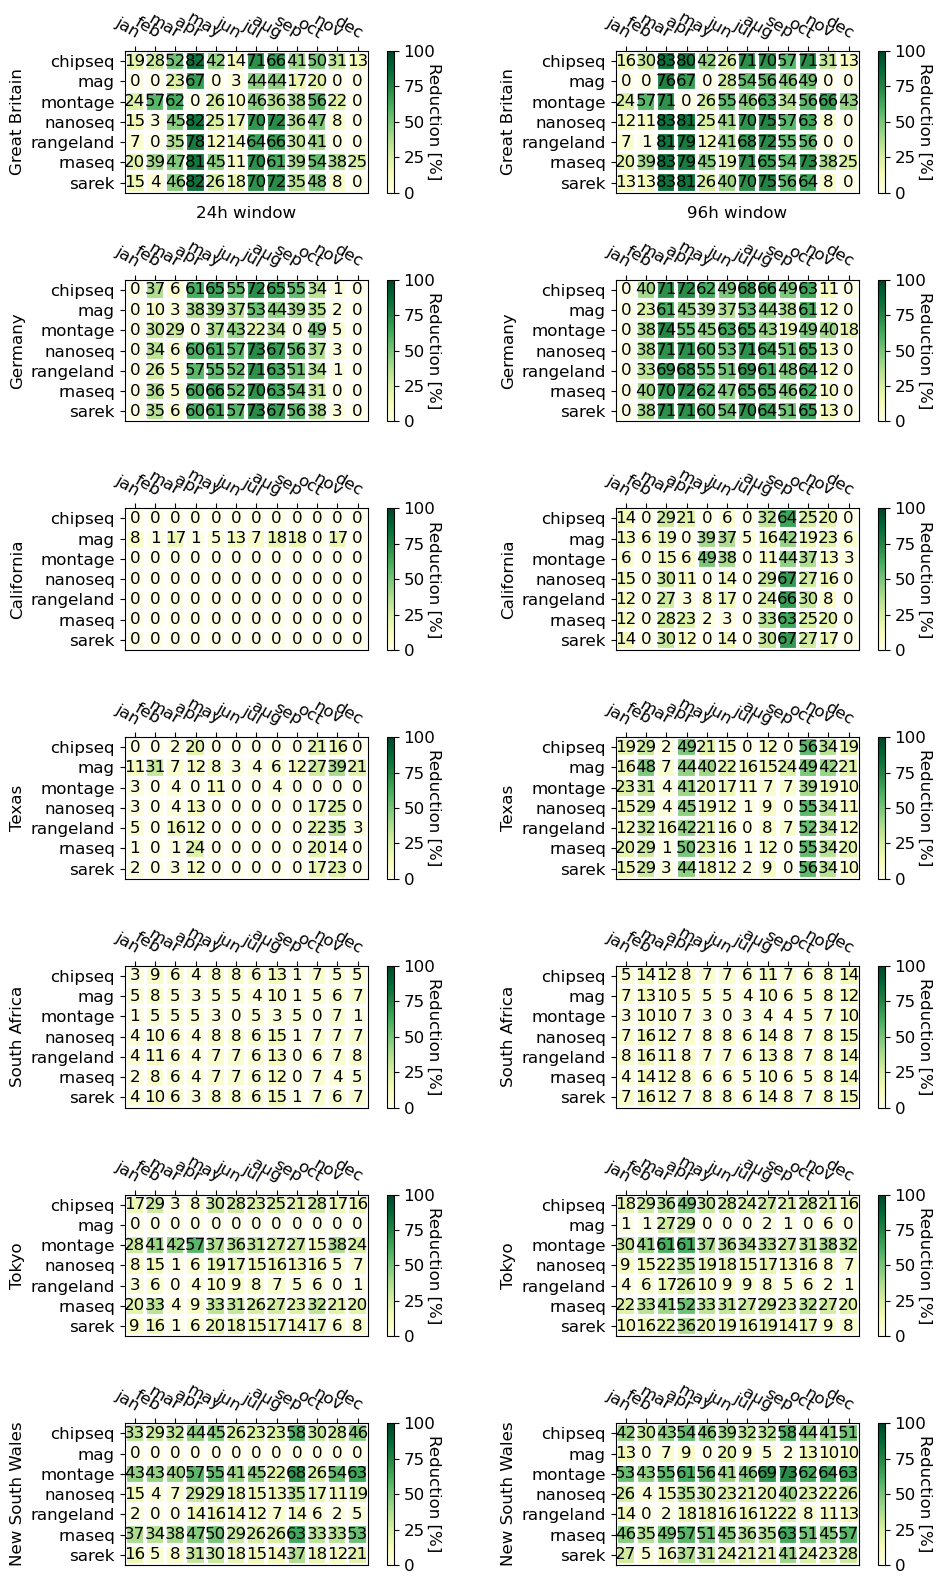

In [126]:
print('Entire Workflow Shifting (Average CI)')
plt.rcParams.update({'font.size': 12})

fig, ax = plt.subplots(nrows=7, ncols=2, figsize=(10,16))  # one plot per region

im_gb, cbar_gb = heatmap(readings_24h_by_region['gb'], workflows, short_months, ax=ax[0][0], cmap="YlGn", cbarlabel="Reduction [%]")
texts_gb = annotate_heatmap(im_gb, valfmt="{x:.0f}")
ax[0][0].set_ylabel('Great Britain')

im_gb, cbar_gb = heatmap(readings_96h_by_region['gb'], workflows, short_months, ax=ax[0][1], cmap="YlGn", cbarlabel="Reduction [%]")
texts_gb = annotate_heatmap(im_gb, valfmt="{x:.0f}")
ax[0][1].set_ylabel('Great Britain')

im_de, cbar_de = heatmap(readings_24h_by_region['de'], workflows, short_months, ax=ax[1][0], cmap="YlGn", cbarlabel="Reduction [%]")
texts_de = annotate_heatmap(im_de, valfmt="{x:.0f}")
ax[1][0].set_ylabel('Germany')

im_de, cbar_de = heatmap(readings_96h_by_region['de'], workflows, short_months, ax=ax[1][1], cmap="YlGn", cbarlabel="Reduction [%]")
texts_de = annotate_heatmap(im_de, valfmt="{x:.0f}")
ax[1][1].set_ylabel('Germany')

im_ca, cbar_ca = heatmap(readings_24h_by_region['ca'], workflows, short_months, ax=ax[2][0], cmap="YlGn", cbarlabel="Reduction [%]")
texts_ca = annotate_heatmap(im_ca, valfmt="{x:.0f}")
ax[2][0].set_ylabel('California')

im_ca, cbar_ca = heatmap(readings_96h_by_region['ca'], workflows, short_months, ax=ax[2][1], cmap="YlGn", cbarlabel="Reduction [%]")
texts_ca = annotate_heatmap(im_ca, valfmt="{x:.0f}")
ax[2][1].set_ylabel('California')

im_tx, cbar_tx = heatmap(readings_24h_by_region['tx'], workflows, short_months, ax=ax[3][0], cmap="YlGn", cbarlabel="Reduction [%]")
texts_tx = annotate_heatmap(im_tx, valfmt="{x:.0f}")
ax[3][0].set_ylabel('Texas')

im_tx, cbar_tx = heatmap(readings_96h_by_region['tx'], workflows, short_months, ax=ax[3][1], cmap="YlGn", cbarlabel="Reduction [%]")
texts_tx = annotate_heatmap(im_tx, valfmt="{x:.0f}")
ax[3][1].set_ylabel('Texas')

im_zaf, cbar_zaf = heatmap(readings_24h_by_region['zaf'], workflows, short_months, ax=ax[4][0], cmap="YlGn", cbarlabel="Reduction [%]")
texts_zaf = annotate_heatmap(im_zaf, valfmt="{x:.0f}")
ax[4][0].set_ylabel('South Africa')

im_zaf, cbar_zaf = heatmap(readings_96h_by_region['zaf'], workflows, short_months, ax=ax[4][1], cmap="YlGn", cbarlabel="Reduction [%]")
texts_zaf = annotate_heatmap(im_zaf, valfmt="{x:.0f}")
ax[4][1].set_ylabel('South Africa')

im_tyo, cbar_tyo = heatmap(readings_24h_by_region['tyo'], workflows, short_months, ax=ax[5][0], cmap="YlGn", cbarlabel="Reduction [%]")
texts_tyo = annotate_heatmap(im_tyo, valfmt="{x:.0f}")
ax[5][0].set_ylabel('Tokyo')

im_tyo, cbar_tyo = heatmap(readings_96h_by_region['tyo'], workflows, short_months, ax=ax[5][1], cmap="YlGn", cbarlabel="Reduction [%]")
texts_tyo = annotate_heatmap(im_tyo, valfmt="{x:.0f}")
ax[5][1].set_ylabel('Tokyo')

im_nsw, cbar_nsw = heatmap(readings_24h_by_region['nsw'], workflows, short_months, ax=ax[6][0], cmap="YlGn", cbarlabel="Reduction [%]")
texts_nsw = annotate_heatmap(im_nsw, valfmt="{x:.0f}")
ax[6][0].set_ylabel('New South Wales')

im_nsw, cbar_nsw = heatmap(readings_96h_by_region['nsw'], workflows, short_months, ax=ax[6][1], cmap="YlGn", cbarlabel="Reduction [%]")
texts_nsw = annotate_heatmap(im_nsw, valfmt="{x:.0f}")
ax[6][1].set_ylabel('New South Wales')

ax[0][0].set_xlabel('24h window')
ax[0][1].set_xlabel('96h window')

fig.tight_layout()
plt.savefig('../image/cf-reduction-entshift-avg.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [120]:
# Function to Plot for a single region? 
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
plt.rcParams.update({'font.size': 16})


def plot_single_region(data_24h, data_96h, outname):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(11,3))

    im_gb, cbar_gb = heatmap(data_24h, workflows, short_months, ax=ax[0], cmap="YlGn", cbarlabel="Reduction [%]")
    texts_gb = annotate_heatmap(im_gb, valfmt="{x:.0f}")

    im_gb, cbar_gb = heatmap(data_96h, workflows, short_months, ax=ax[1], cmap="YlGn", cbarlabel="Reduction [%]", ignorewf=True)
    texts_gb = annotate_heatmap(im_gb, valfmt="{x:.0f}")

    ax[0].set_xlabel('24h window')
    ax[1].set_xlabel('96h window')
    fig.tight_layout()
    plt.savefig(f'../image/{outname}.pdf', dpi=300, bbox_inches='tight')
    plt.show()


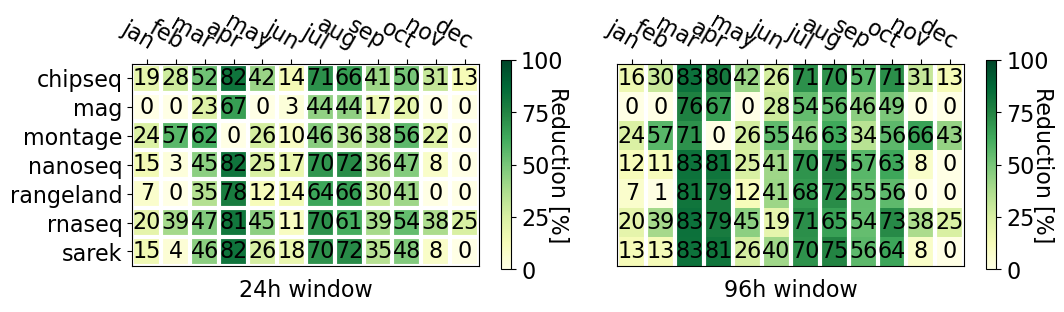

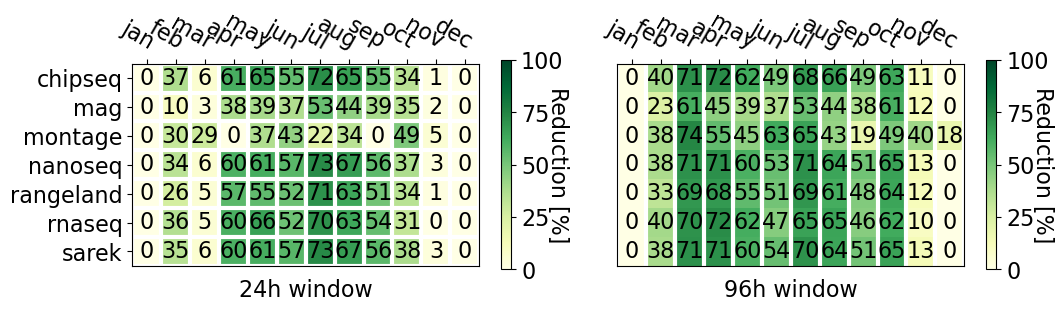

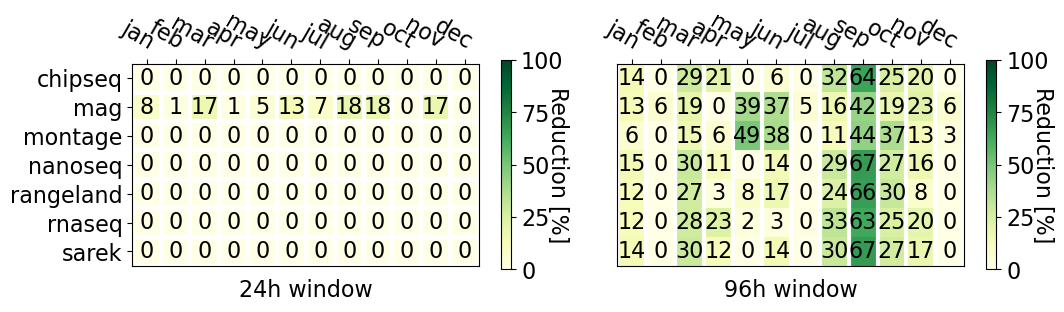

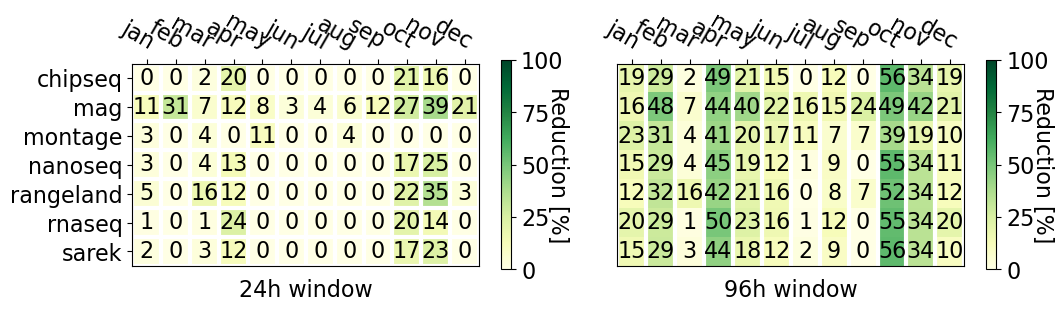

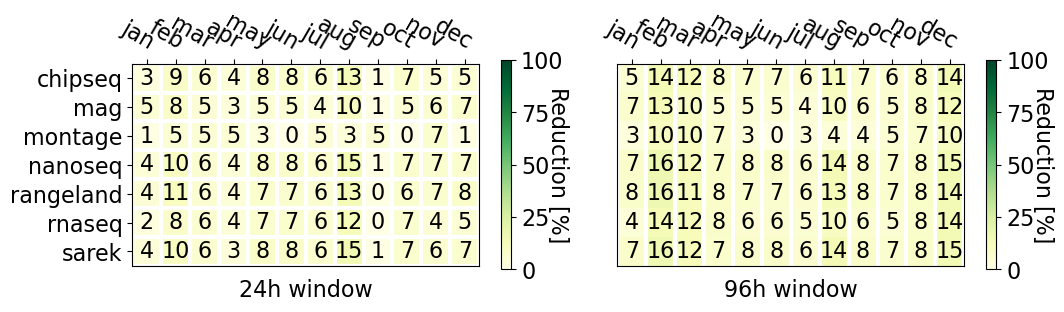

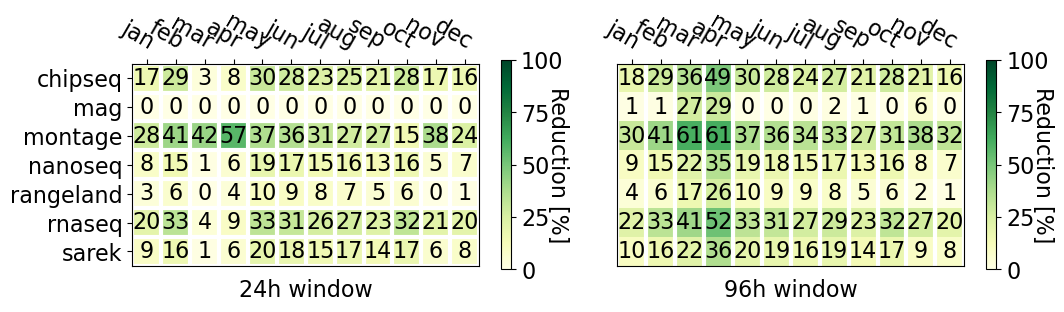

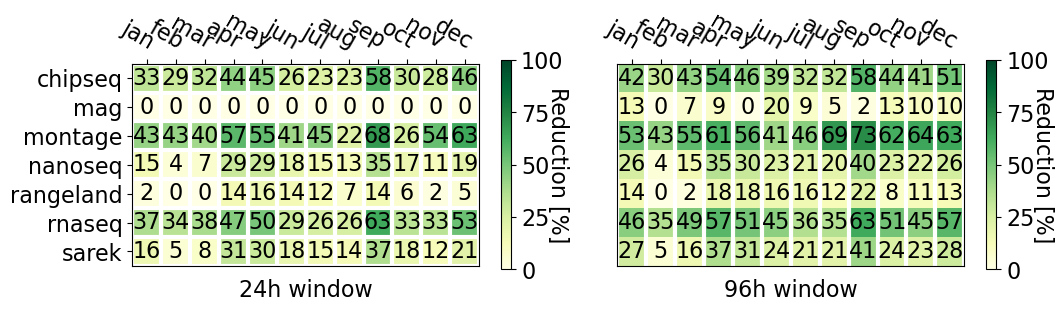

In [122]:
# Plot Separately for each region ? 
for region in short_regions:
    plot_single_region(readings_24h_by_region[region], readings_96h_by_region[region], f'entshift-{region}-avg')


In [9]:
# Explore 24h flexibility window (marg)
marg_readings_24h = parse_readings(window=24, marg='-marg')
marg_readings_24h_by_region = {}

for region in short_regions:
    curr = []
    for workflow in workflows:
        curr.append(marg_readings_24h[region][workflow])
    marg_readings_24h_by_region[region] = np.array(curr)

In [10]:
# Explore 96h flexibility window (marg)
marg_readings_96h = parse_readings(window=96, marg='-marg')
marg_readings_96h_by_region = {}

for region in short_regions:
    curr = []
    for workflow in workflows:
        curr.append(marg_readings_96h[region][workflow])
    marg_readings_96h_by_region[region] = np.array(curr)

Entire Workflow Shifting (Marginal CI)


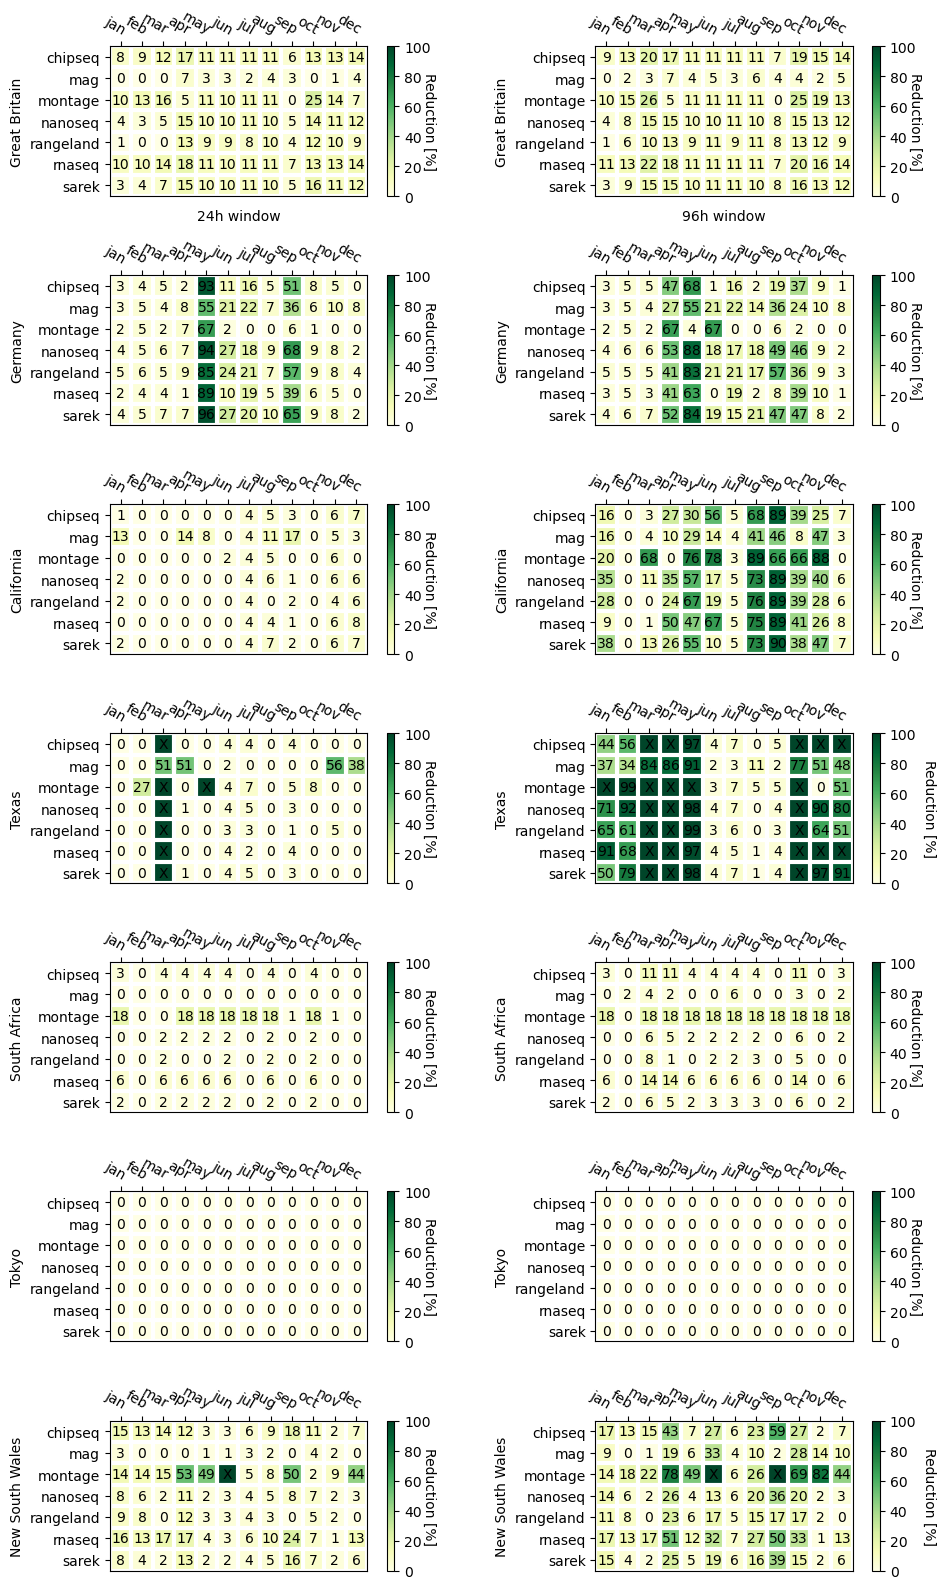

In [11]:
print('Entire Workflow Shifting (Marginal CI)')

fig, ax = plt.subplots(nrows=7, ncols=2, figsize=(10,16))  # one plot per region

im_gb, cbar_gb = heatmap(marg_readings_24h_by_region['gb'], workflows, short_months, ax=ax[0][0], cmap="YlGn", cbarlabel="Reduction [%]")
texts_gb = annotate_heatmap(im_gb, valfmt="{x:.0f}")
ax[0][0].set_ylabel('Great Britain')

im_gb, cbar_gb = heatmap(marg_readings_96h_by_region['gb'], workflows, short_months, ax=ax[0][1], cmap="YlGn", cbarlabel="Reduction [%]")
texts_gb = annotate_heatmap(im_gb, valfmt="{x:.0f}")
ax[0][1].set_ylabel('Great Britain')

im_de, cbar_de = heatmap(marg_readings_24h_by_region['de'], workflows, short_months, ax=ax[1][0], cmap="YlGn", cbarlabel="Reduction [%]")
texts_de = annotate_heatmap(im_de, valfmt="{x:.0f}")
ax[1][0].set_ylabel('Germany')

im_de, cbar_de = heatmap(marg_readings_96h_by_region['de'], workflows, short_months, ax=ax[1][1], cmap="YlGn", cbarlabel="Reduction [%]")
texts_de = annotate_heatmap(im_de, valfmt="{x:.0f}")
ax[1][1].set_ylabel('Germany')

im_ca, cbar_ca = heatmap(marg_readings_24h_by_region['ca'], workflows, short_months, ax=ax[2][0], cmap="YlGn", cbarlabel="Reduction [%]")
texts_ca = annotate_heatmap(im_ca, valfmt="{x:.0f}")
ax[2][0].set_ylabel('California')

im_ca, cbar_ca = heatmap(marg_readings_96h_by_region['ca'], workflows, short_months, ax=ax[2][1], cmap="YlGn", cbarlabel="Reduction [%]")
texts_ca = annotate_heatmap(im_ca, valfmt="{x:.0f}")
ax[2][1].set_ylabel('California')

im_tx, cbar_tx = heatmap(marg_readings_24h_by_region['tx'], workflows, short_months, ax=ax[3][0], cmap="YlGn", cbarlabel="Reduction [%]")
texts_tx = annotate_heatmap(im_tx, valfmt="{x:.0f}")
ax[3][0].set_ylabel('Texas')

im_tx, cbar_tx = heatmap(marg_readings_96h_by_region['tx'], workflows, short_months, ax=ax[3][1], cmap="YlGn", cbarlabel="Reduction [%]")
texts_tx = annotate_heatmap(im_tx, valfmt="{x:.0f}")
ax[3][1].set_ylabel('Texas')

im_zaf, cbar_zaf = heatmap(marg_readings_24h_by_region['zaf'], workflows, short_months, ax=ax[4][0], cmap="YlGn", cbarlabel="Reduction [%]")
texts_zaf = annotate_heatmap(im_zaf, valfmt="{x:.0f}")
ax[4][0].set_ylabel('South Africa')

im_zaf, cbar_zaf = heatmap(marg_readings_96h_by_region['zaf'], workflows, short_months, ax=ax[4][1], cmap="YlGn", cbarlabel="Reduction [%]")
texts_zaf = annotate_heatmap(im_zaf, valfmt="{x:.0f}")
ax[4][1].set_ylabel('South Africa')

im_tyo, cbar_tyo = heatmap(marg_readings_24h_by_region['tyo'], workflows, short_months, ax=ax[5][0], cmap="YlGn", cbarlabel="Reduction [%]")
texts_tyo = annotate_heatmap(im_tyo, valfmt="{x:.0f}")
ax[5][0].set_ylabel('Tokyo')

im_tyo, cbar_tyo = heatmap(marg_readings_96h_by_region['tyo'], workflows, short_months, ax=ax[5][1], cmap="YlGn", cbarlabel="Reduction [%]")
texts_tyo = annotate_heatmap(im_tyo, valfmt="{x:.0f}")
ax[5][1].set_ylabel('Tokyo')

im_nsw, cbar_nsw = heatmap(marg_readings_24h_by_region['nsw'], workflows, short_months, ax=ax[6][0], cmap="YlGn", cbarlabel="Reduction [%]")
texts_nsw = annotate_heatmap(im_nsw, valfmt="{x:.0f}")
ax[6][0].set_ylabel('New South Wales')

im_nsw, cbar_nsw = heatmap(marg_readings_96h_by_region['nsw'], workflows, short_months, ax=ax[6][1], cmap="YlGn", cbarlabel="Reduction [%]")
texts_nsw = annotate_heatmap(im_nsw, valfmt="{x:.0f}")
ax[6][1].set_ylabel('New South Wales')

ax[0][0].set_xlabel('24h window')
ax[0][1].set_xlabel('96h window')
fig.tight_layout()
plt.savefig('../image/cf-reduction-entshift-marg.pdf', dpi=300, bbox_inches='tight')
plt.show()

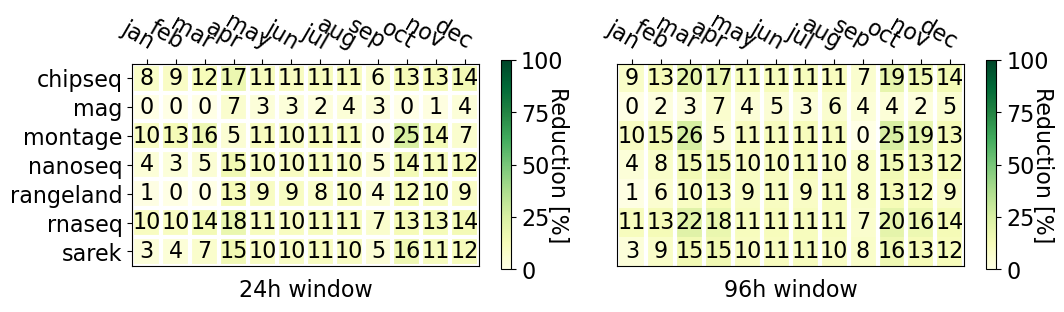

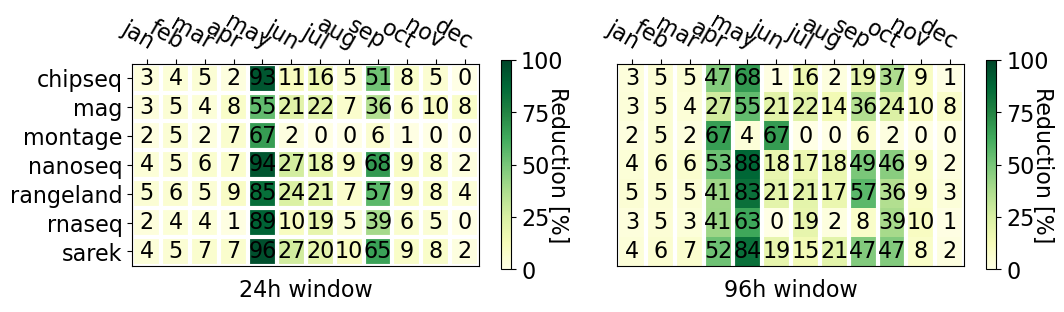

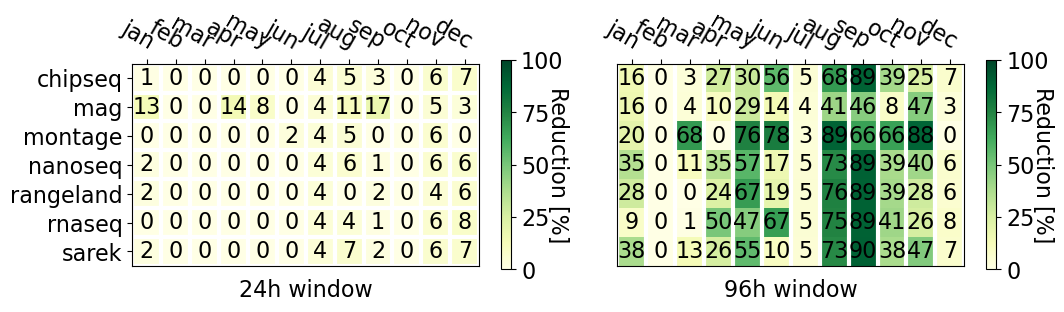

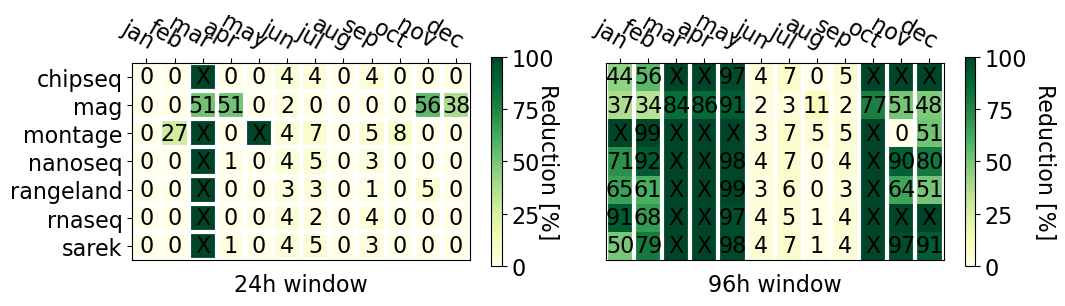

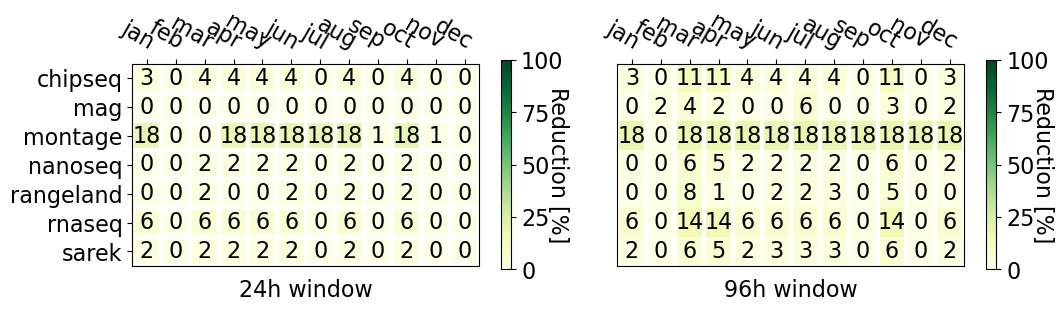

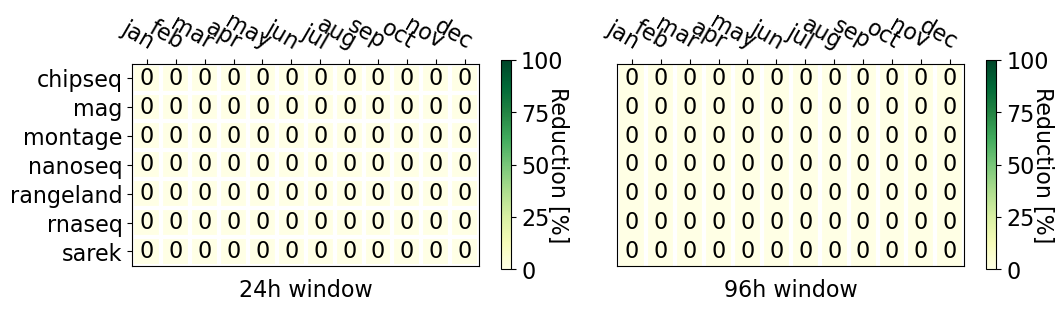

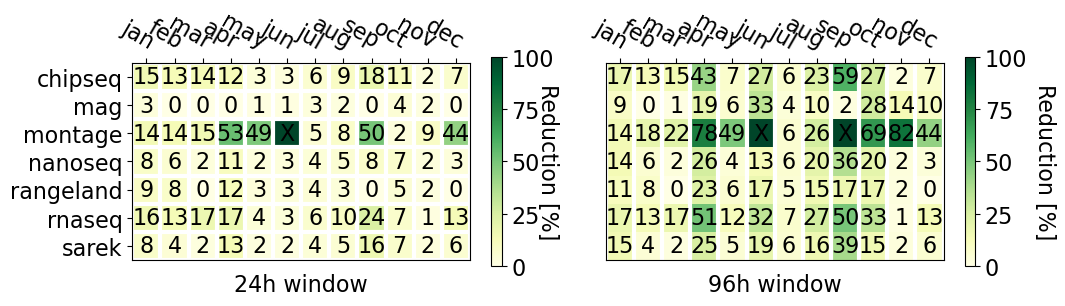

In [123]:
# Plot Separately for each region ? 
for region in short_regions:
    plot_single_region(marg_readings_24h_by_region[region], marg_readings_96h_by_region[region], f'entshift-{region}-marg')